In [32]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

'''
Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

```python
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
```

Submodules assigned in this way will be registered, and will have their parameters converted too when you call to(), etc.
'''
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 10)
        # print(list(self.parameters()))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        # x = F.softmax(x, dim=1) # CrossEntropyLoss() already has softmax
        return x

    def train(self, train_loader: torch.utils.data.DataLoader, lr: float):
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        optimizer.zero_grad()
        for images, label in tqdm(train_loader):
            y = self.forward(images)
            loss = F.cross_entropy(y, label)
            loss.backward()
            optimizer.step()

    def test(self, test_loader: torch.utils.data.DataLoader) -> float:
        correct = 0
        total = 0
        with torch.no_grad():
            for images, label in tqdm(test_loader):
                y = self.forward(images)
                predicted = torch.argmax(y, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
        return correct / total
    
    def display_layer1_weights(self):
        fig, axs = plt.subplots(50, 10, figsize=(20, 100))
        for r in range(50):
            for c in range(10):
                axs[r, c].imshow(self.layer1.weight[10*r + c].view(28, 28).detach().numpy())
        fig.savefig("layer1_weights.png")

model = MLP()
try:
    print("Loading saved model")
    model.load_state_dict(torch.load("mlp.pt"))
except:
    print("No saved model found, training from scratch")
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=True)
    model.train(train_loader, lr=0.01)
    print("Accuracy:", model.test(test_loader))

    torch.save(model.state_dict(), "mlp.pt")

Loading saved model
No saved model found, training from scratch


100%|██████████| 100/100 [00:01<00:00, 99.74it/s]

Accuracy: 0.9117


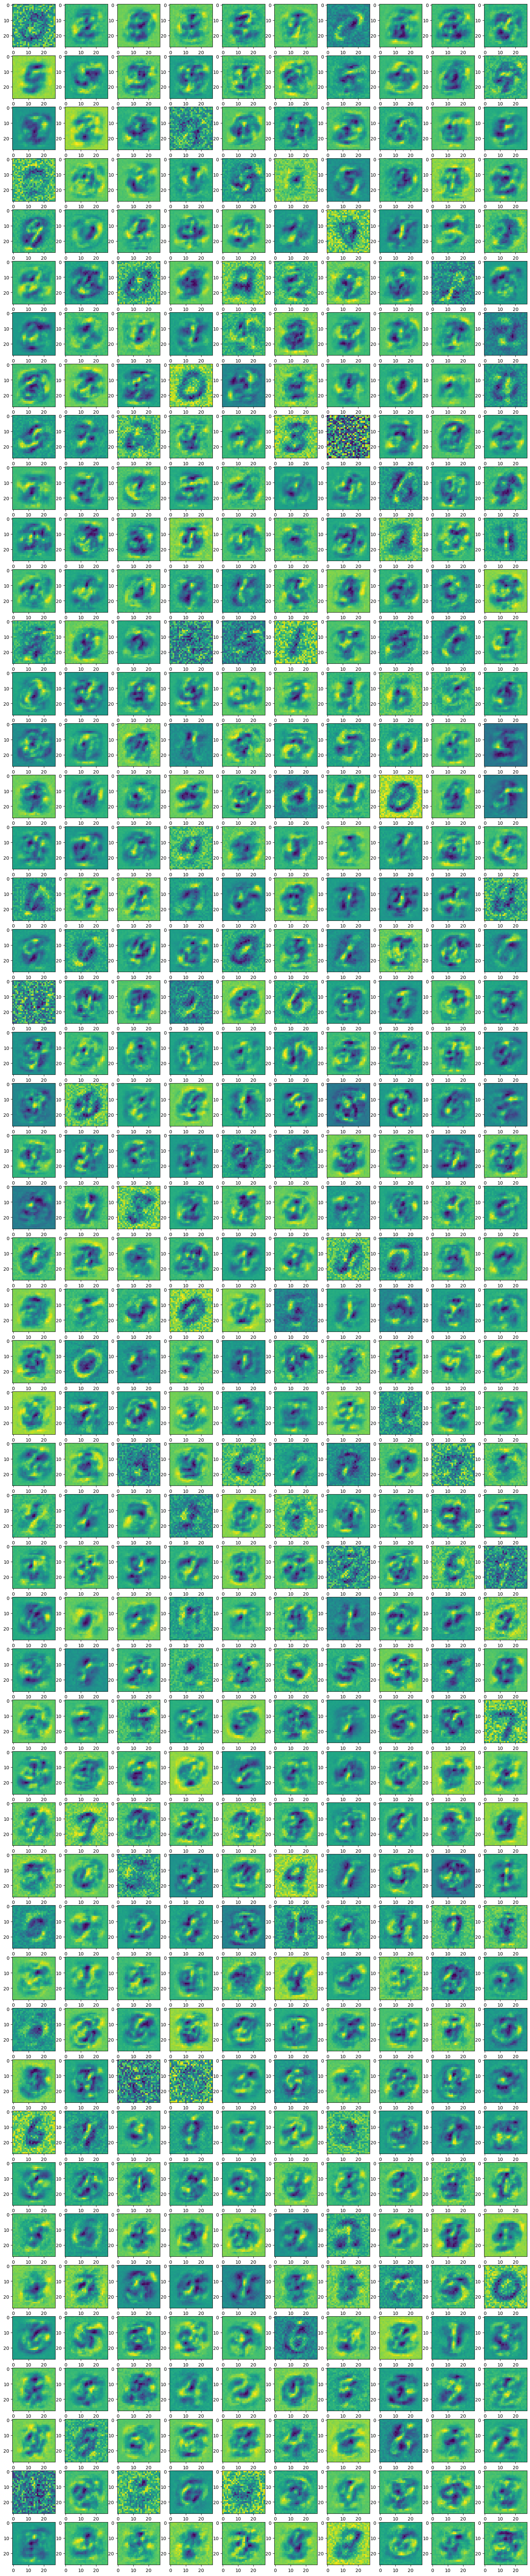

In [30]:
model.display_layer1_weights()